In [22]:
from IPython.display import Image, display


Display image: apple.jpg


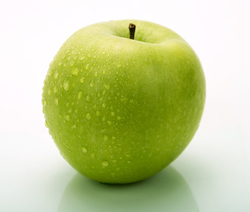


Display image: clock.jpg


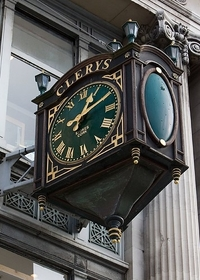


Display image: oranges.jpg


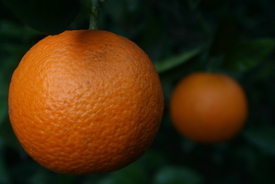


Display image: car.jpg


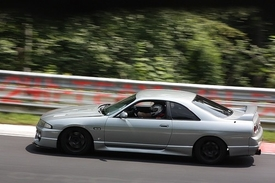

In [23]:
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f'\nDisplay image: {image_file}')
    display(Image(filename=f'images/{image_file}'))

In [24]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [25]:
import cv2

# Suppress Tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box (filename, model='yolov3-tiny', confidence=0.5):
    """Detects commmon objects on an image and creates a new image with bouinding boxes
    
    Args:
        filename(str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". defaults to "yolov3-tiny".
        confidence (float, optional): Desired confindence level. Defaults to 0.5
    """

    # images are stored under the images/ directory
    img_filepath = f'images/{filename}'

    # REad the image into a numpy array
    img = cv2.imread(img_filepath)

    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model = model)

    # print current image's detection
    print(f"============================\nImage processed: {filename}\n")

    # Print detected objects with confidence level

    for l, c in zip (label, conf):
        print(f"Detected object: {l} with confindence level of {c}\n")

    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)

    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)

    # display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))


Image processed: apple.jpg

Detected object: apple with confindence level of 0.5717183351516724



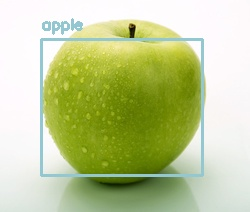

Image processed: clock.jpg

Detected object: clock with confindence level of 0.968317985534668



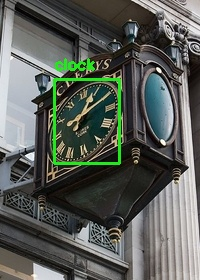

Image processed: oranges.jpg

Detected object: orange with confindence level of 0.6185599565505981

Detected object: orange with confindence level of 0.5561732053756714



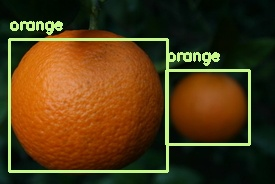

Image processed: car.jpg

Detected object: car with confindence level of 0.6325422525405884



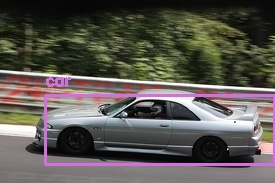

In [26]:
for image_file in image_files:
    detect_and_draw_box(image_file)

### Changing the confidence level

Image processed: fruits.jpg

Detected object: apple with confindence level of 0.5818485617637634

Detected object: orange with confindence level of 0.5346476435661316

Detected object: orange with confindence level of 0.5150948166847229



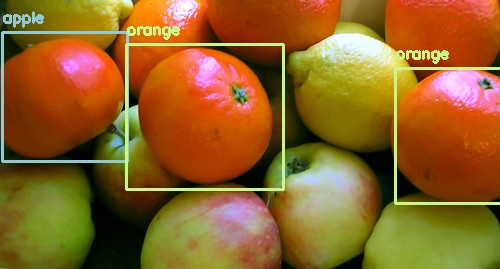

In [27]:
detect_and_draw_box('fruits.jpg')

Image processed: fruits.jpg

Detected object: apple with confindence level of 0.5818485617637634

Detected object: orange with confindence level of 0.5346476435661316

Detected object: orange with confindence level of 0.5150948166847229

Detected object: apple with confindence level of 0.3476020395755768

Detected object: orange with confindence level of 0.32876279950141907

Detected object: apple with confindence level of 0.3124457597732544

Detected object: orange with confindence level of 0.27985894680023193

Detected object: orange with confindence level of 0.27499887347221375

Detected object: apple with confindence level of 0.2744504511356354

Detected object: orange with confindence level of 0.21419422328472137



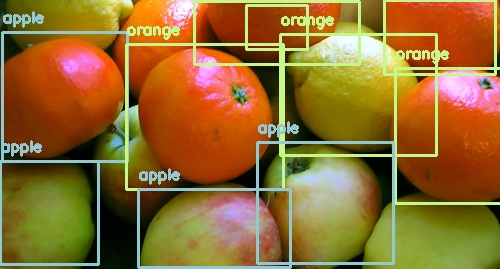

In [28]:
detect_and_draw_box('fruits.jpg', confidence=0.2)

### Deploying the model using FastAPI
#### placing the model on a server

In [29]:
dir_name = 'images_uploaded'
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

In [30]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [33]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying an ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://serve/docs"


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

In [37]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# this is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!
uvicorn.run(app, host=host, port =8000, root_path='/serve')

INFO:     Started server process [7016]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:63290 - "GET /serve/ HTTP/1.1" 200 OK
INFO:     127.0.0.1:63290 - "GET /serve/docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:63290 - "GET /serve/serve/openapi.json HTTP/1.1" 404 Not Found


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [7016]
Task exception was never retrieved
future: <Task finished name='Task-48' coro=<Server.serve() done, defined at c:\Users\mbele\Desktop\NLP O'Reily\nlp\lib\site-packages\uvicorn\server.py:67> exception=SystemExit(1)>
Traceback (most recent call last):
  File "c:\Users\mbele\Desktop\NLP O'Reily\nlp\lib\site-packages\uvicorn\server.py", line 162, in startup
    server = await loop.create_server(
  File "C:\Users\mbele\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1519, in create_server
    raise OSError(err.errno, 'error while attempting '
OSError: [Errno 10048] error while attempting to bind on address ('127.0.0.1', 8000): only one usage of each socket address (protocol/network address/port) is normally permitted

During handling of the above exception, another exception occurred:

Traceback (most recent call last

KeyboardInterrupt: 